<a href="https://colab.research.google.com/github/omanshuthapliyal/formationControl/blob/master/SupervisoryControlAttack_formation_of_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining ***Robot Formation*** model.

Adapted from [Hybrid Control of Formation of Robots](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=932546).



In [0]:
from numpy import matmul 
import numpy as np
from numpy import pi
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from math import sin, cos, acos, atan, sqrt
import scipy.integrate as integrate
from copy import copy

## Plant Objects

In [0]:
def stateProp(xDot, x, t, dt):
  # xDot = dx/dt = constant during dT, x = x(t), dt = Delta T
  dx = xDot*dt
  return (x + dx)
  
class PLANT:
  def __init__(self, rIN):
    self.r = rIN # Sensor radius, unspecified in the paper
    
    # See beginning of section 4
    eps = 0.0001
    self.d = 0.1  # Robot dimension
    self.l_des = [[0, 1, 1],
                  [1, 0, 1],
                  [1, 1, 0]]
    # See Eq. 19
    d12 = pi/2
    d13 = acos((self.l_des[0][1]**2 + self.l_des[0][2]**2 - self.l_des[1][2]**2)/
               (2*self.l_des[0][1]*self.l_des[0][2])) + d12
    d23 = pi + pi/6
    self.psi_des = [[eps, d12, d13],
                    [d12, eps, d23],
                    [d13, d23, eps]]
    self.t = 0
    self.dt = 0.1
    self.l = [[eps, 1.5, sqrt(1.04)],
              [1.5, eps, sqrt(5.69)],
              [sqrt(1.04), sqrt(5.69), eps]]
    self.lDot = np.zeros_like(self.l)
    self.psi = [[eps, -pi/6, -pi/6 + atan(10)],
                [-pi/6, eps, pi - atan(2/1.3)],
                [-pi/6 + atan(10), pi - atan(2/1.3), eps]]
    self.psiDot = np.zeros_like(self.psi)
    # Initial conditions in global coordinates
    self.x = np.array([eps, 1.5, 0.2])
    self.y = np.array([eps, eps, 2])
    self.theta = np.array([pi/6, eps, pi/6])
    self.thetaDot = np.zeros_like(self.theta)
    self.v = np.array([0.5,eps,eps])
    self.w = np.array([0.1*sin(0.2*self.t), eps, eps])

    self.xDot = np.zeros_like(self.x)
    self.xDot[0] = self.v[0]*cos(self.theta[0])
    self.yDot = np.zeros_like(self.x)
    self.yDot[0] = self.v[0]*sin(self.theta[0])
    self.thetaDot[0] = self.w[0]
    
    self.k1 = 1.5
    self.k2 = 1.5
    self.k3 = 1.5

    self.modes = np.array([np.nan, np.nan, np.nan])

  def SB_ijC(self,i,j):
    # Robots j follows Robot i
    
    # Global coordinate equations from Eq 2-4
    gamma_ij = self.theta[i] - self.theta[j] + self.psi[i][j]
    s_ij = self.k1 * (self.l_des[i][j] - self.l[i][j])
    b_ij = self.k2 * (self.psi_des[i][j] - self.psi[i][j])
    # Eqs. 2-3
    self.v[j] = ( s_ij * cos(gamma_ij) - self.l[i][j] * sin(gamma_ij) * (b_ij + self.w[i]) + 
                 self.v[i]*cos(self.theta[i]-self.theta[j]) )
    self.w[j] = ( s_ij * sin(gamma_ij) + self.l[i][j] * cos(gamma_ij) * (b_ij + self.w[i]) + 
                 self.v[i]*sin(self.theta[i]-self.theta[j]) )/self.d

    # See Eqs. 15 - 17
    self.lDot[i][j] = s_ij
    self.psiDot[i][j] = b_ij
    self.thetaDot[j] = copy(self.w[j])

  def S_ikS_jkC(self,i,j,k):
    # Robot k follows Robots i & j
    # Global coordinate equations from Eqs 6-7
    gamma_jk = self.theta[j] - self.theta[k] + self.psi[j][k]
    gamma_ik = self.theta[i] - self.theta[k] + self.psi[i][k]

    s_ik = self.k1 * (self.l_des[i][k] - self.l[i][k])
    s_jk = self.k1 * (self.l_des[j][k] - self.l[j][k])

    self.v[k] = (  s_ik * sin(gamma_jk) - s_jk * sin(gamma_ik) + 
                 self.v[i]*cos(self.psi[i][k]) * sin(gamma_jk) -
                 self.v[j]*cos(self.psi[j][k]) * sin(gamma_ik) )/(sin(gamma_jk - gamma_ik))
    self.w[k] = ( -s_ik * cos(gamma_jk) + s_jk * cos(gamma_ik) - 
                 self.v[i]*cos(self.psi[i][k]) * cos(gamma_jk) +
                 self.v[j]*cos(self.psi[j][k]) * cos(gamma_ik) )/(self.d * sin(gamma_jk - gamma_ik))

    self.lDot[i][k] = s_ik
    self.lDot[j][k] = s_jk
    self.thetaDot[k] = copy(self.w[k])

    # self.psi[i][k] = stateProp(self.psiDot[i][k],
    #                       self.psi[i][k], self.t, self.dt)
    # self.psi[j][k] = stateProp(self.psiDot[j][k],
    #                   self.psi[j][k], self.t, self.dt)

  def autoNavig(self, i):
    self.xDot[i] = self.v[i]*cos(self.theta[i])
    self.yDot[i] = self.v[i]*sin(self.theta[i])
    self.thetaDot[i] = copy(self.w[i])
    
  def updatePosition(self, i):
    # Update the position of robot i following robot 1
    # Updates using position of Robot 1
    
    self.theta[i] = stateProp(self.thetaDot[i], 
                              self.theta[i], 
                              self.t, self.dt)
    self.y[i] = stateProp(self.yDot[i], 
                          self.y[i], self.t, self.dt)
    self.x[i] = stateProp(self.xDot[i], 
                          self.x[i], self.t, self.dt)
    
    for n in range(3):
      self.l[n][i] = np.linalg.norm([self.x[n] - self.x[i] ,
                                     self.y[n] - self.y[i]])
      
      self.psi[n][i] = stateProp(self.psiDot[n][i],
                          self.psi[n][i], 
                          self.t, self.dt)

  def letUsUpdate(self,i):
    self.autoNavig(i)
    self.updatePosition(i) 

  def propagate(self, supervObj, i):
    # ID = 1, 2, 3 are robot numbers. We are interested in Robot 3
    if i == 0:
      # leader's dynamics are given by Eq. 1
      self.w[i] = 0.1*sin(0.2*self.t)
      self.letUsUpdate(i)

    elif i == 1:
      # Robot 2 is always in SB_12C mode,that is, following robot 1
      self.SB_ijC(0,1)    # (1,2) = (0,1) due to zero indexing
      self.letUsUpdate(i)
    
    else:
      # Choose mode for Robot 3
      mode = supervObj.switch(self, self.l[0][2], self.l[1][2])
      if mode == 1: 
        self.SB_ijC(0,2)         # Robot 3 follows Robot 1
      elif mode == 2: 
        self.SB_ijC(1,2)         # Robot 3 follows Robot 2
      elif mode == 3: 
        self.S_ikS_jkC(0,2,1)    # Robot 3 follows Robot 1 & 2 
      elif mode == 4: pass       # Autonomous Navigation for Robot 3
      self.letUsUpdate(i)
      self.modes[i] = mode

## Supervisor Model

In [0]:
 class supervisor:
    def switch(self, Plant, l13, l23):
    # Supervisory Logic for Robot 3, where it can detect robots 1 & 2
    # based on Section 3.1
      b1 = ((l13 < l23) and (l23 > Plant.r[0]) and
            (l13 < Plant.r[1]) )
      b2 = ((l13 > l23) and (l13 > Plant.r[0]) and
            (l23 < Plant.r[1]) )
      b3 = (l13 < Plant.r[0]) and (l23 < Plant.r[0])
      b4 = (l13 > Plant.r[1]) and (l23 > Plant.r[1])
      if b1: return 1
      elif b2: return 2
      elif b3: return 3
      elif b4: return 4

## Propagate plant to simulate supervisor
Not used in training, only to visualize plant behaviour

In [0]:
# Initial parameters for running plant 
# r = np.array([0.5, 1.2, 2])
r = np.array([0.75, 1.2, 2])
ROBOTS = PLANT(r)
tSim = 30
SUPER = supervisor()
tHISTORY = np.zeros((int(tSim/ROBOTS.dt)+1,1))
xHISTORY = np.zeros((tHISTORY.size,3))
yHISTORY = np.zeros_like(xHISTORY)
thetaHISTORY = np.zeros_like(xHISTORY)
modeHISTORY = np.zeros_like(tHISTORY)
for t in range(tHISTORY.size):
# Looping across time
  for i in range(3):
    # Looping over robots
    xHISTORY[t][i] = ROBOTS.x[i]
    yHISTORY[t][i] = ROBOTS.y[i]
    thetaHISTORY[t][i] = ROBOTS.theta[i]
    modeHISTORY[t] = ROBOTS.modes[2]
    tHISTORY[t] = ROBOTS.t
    ROBOTS.propagate(SUPER,i)
  ROBOTS.t += ROBOTS.dt

In [0]:
def modePlotter(modeHISTORY, filename, saveTag=False):
  # Plotting mode change for Robot 3
  plt.plot(tHISTORY, modeHISTORY)
  if saveTag:
    plt.savefig(filename)
    files.download(filename)
  plt.show()

def trajectoryPlotter(xHISTORY, yHISTORY, filename, saveTag=False):
  # Plotting trajectories:
  colors = ['k-','g-','r:']
  for j in range(3):
    plt.plot(xHISTORY[0,j], yHISTORY[0,j], 'ko')
    plt.plot(xHISTORY[-1,j], yHISTORY[-1,j], 'ko')

  for i in range(3):
    plt.plot( xHISTORY[:,i], yHISTORY[:,i],
            colors[i], 
            label = "Robot "+str(i+1))
  plt.xlim(-8,8)
  plt.ylim(-0.2,14)
  plt.grid(True)
  plt.axis('scaled')
  plt.legend(loc='upper left')
  plt.title('Robot trajectories over time')
  plt.xlabel("$x$")
  plt.ylabel("$y$")
  if saveTag:
    plt.savefig(filename)
    files.download(filename)
  plt.show()


In [0]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
!pwd


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content


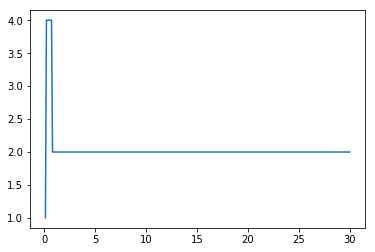

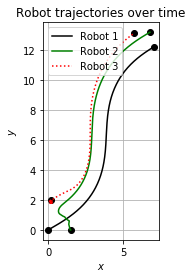

In [0]:
modePlotter(modeHISTORY, "modes1.eps")
# files.download("modes1.eps")

trajectoryPlotter(xHISTORY, yHISTORY, "traj1.eps")
# files.download("traj1.eps")



plt.savefig("modes1.eps")
files.download('modes1.eps')
# Building Statistical model of Supervisory logic

## Making Queries to the Supervisor object

In [0]:
#Import necessary packages
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Making Queries to the Supervisor
SUPER2 = supervisor()
DUMMY = PLANT(r)    # Using same 'r' as that is a sensor property and can be easily found
nDim = 2
nModes = 4
# mean = np.zeros(nDim)
# cov = np.eye(nDim)*100
Low = 0
High = 3
nQueries = 500
# Collecting data from Queries
data = np.zeros((nQueries, nDim))
labels = np.zeros(nQueries)
counts = np.empty((nModes, 1))

for i in range(nQueries):
  data[i,:] = np.random.uniform(low = Low, high = High, size = (1,2))
  s = SUPER2.switch(DUMMY, data[i,0], data[i,1])
  if s == 1: 
    counts[s-1]+=1
  elif s==2:
    counts[s-1]+=1
  elif s==3:
    counts[s-1]+=1
  else: counts[s-1]+=1
  labels[i] = s-1  # Because label 0 = mode 1 and so on

print(counts)

k = np.random.choice(nQueries)
# Converting labels to one-hot-vectors
_labels = keras.utils.np_utils.to_categorical(labels, num_classes=4)
# Splitting dataset
split = int(0.75*nQueries)
data_train = data[0:split,:]
labels_train = _labels[0:split,:]
data_test = data[split:,:]
labels_test = _labels[split:,:]


[[131.        ]
 [142.        ]
 [218.97501839]
 [479.84      ]]


## Defining Neural Network Architecture

In [0]:
def NN_arch():
  model = Sequential()

  # Input Layer: accepts nDim number of inputs
  model.add(Dense(units = nDim, 
                  use_bias = True))
                  # kernel_initializer = "uniform"))
  # Second Layer 
  model.add(Dense(units = 8,
                  use_bias = True,
                  # kernel_initializer = "uniform",
                  activation = "relu"))
  # model.add(Dropout(0.10))

  # Third Layer 
  # model.add(Dense(units = 5,
  #                 use_bias = True,
  #                 # kernel_initializer = "uniform",
                  # activation = "relu"))
  # model.add(Dropout(0.10))

  # Output Layer with 4 units
  model.add(Dense(units = nModes,
                  activation = "softmax"))
  return model

## Training model

### Building Model

In [0]:
supervisorApprox = NN_arch()
supervisorApprox.build((None, nDim))
print(supervisorApprox.summary())




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________
None


### Training model

In [0]:
supervisorApprox.compile(loss="mean_squared_error", 
                    optimizer = "adam", 
                    metrics = ['accuracy'])
supervisorApprox_metaData = supervisorApprox.fit(
                data_train, labels_train, 
                validation_data = (data_test, labels_test), 
                epochs = 100, 
                batch_size = 5, 
                shuffle = True)
#Print accuracy of model on testing set after training 
scores = supervisorApprox.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )





Train on 375 samples, validate on 125 samples
Epoch 1/100





375/375 [==============================] - 1s 3ms/step - loss: 0.1311 - acc: 0.7040 - val_loss: 0.1104 - val_acc: 0.7760
Epoch 2/100
375/375 [==============================] - 0s 231us/step - loss: 0.1087 - acc: 0.7333 - val_loss: 0.0927 - val_acc: 0.8160
Epoch 3/100
375/375 [==============================] - 0s 248us/step - loss: 0.0948 - acc: 0.7573 - val_loss: 0.0829 - val_acc: 0.8400
Epoch 4/100
375/375 [==============================] - 0s 306us/step - loss: 0.0858 - acc: 0.7760 - val_loss: 0.0750 - val_acc: 0.8240
Epoch 5/100
375/375 [==============================] - 0s 265us/step - loss: 0.0793 - acc: 0.7813 - val_loss: 0.0700 - val_acc: 0.8080
Epoch 6/100
375/375 [==============================] - 0s 288us/step - loss: 0.0745 - acc: 0.8027 - val_loss: 0.0653 - val_acc: 0.8080
Epoch 7/100
375/375 [==============================] - 0s 253us/step - loss: 0.0712 - acc: 0.8053 - val_loss: 0.0620 - val_acc: 0.8080
Ep

## Model performance

### Model Performance Plots

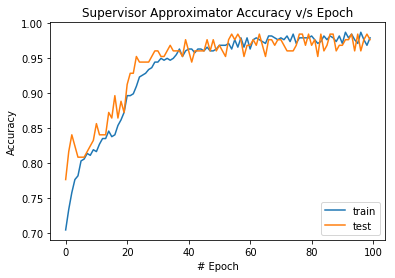

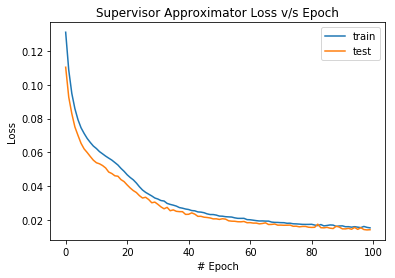

In [0]:
#Plot accuracy vs epoch
plt.plot(supervisorApprox_metaData.history['acc'], label = 'train')
plt.plot(supervisorApprox_metaData.history['val_acc'], label = 'test')
plt.title('Supervisor Approximator Accuracy v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
# plt.ylim(0, 1.1)
plt.show()

#Plot loss vs epoch
plt.plot(supervisorApprox_metaData.history['loss'], label = 'train')
plt.plot(supervisorApprox_metaData.history['val_loss'], label = 'test')
plt.title('Supervisor Approximator Loss v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
# plt.ylim(0,0.5)
plt.show()

### Visualizing Decision Boundary 

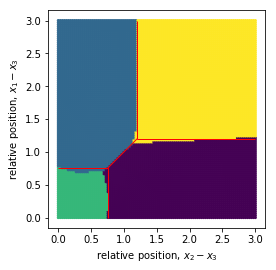

In [0]:
def plotModelOut(x,y,nClasses,model):
  grid = np.stack((x,y))
  grid = grid.T.reshape(-1,2)
  outs = model.predict(grid)
  y1 = outs.T[0].reshape(x.shape[0],x.shape[0])
  plt.contourf(x,y,y1, levels = 100) 
  # Subtracting 1, because levels = n draws n+1 contour lines
  plt.show()
  
def plotModelScatter(x,y,nClasses,model, r1, r2, filename, saveTag):
  # Scattering query data
  grid = np.stack((x,y))
  grid = grid.T.reshape(-1,2)
  labels = model.predict_classes(grid)
  t = np.arange(nClasses)
  n = x.shape[0]
  plt.scatter(x,y,s = 4, c = labels.reshape((n,n)) )
  plt.axis('scaled')
  axes = plt.gca()
  xx = axes.get_xlim()
  lines = [[(r1,0), (r1, r1)], [(r1, r1), (r2, r2)], [(r2, r2), (3, r2)],
           [(0, r1), (r1, r1)], [(r2, r2), (r2, 3)]]
  lc = mc.LineCollection(lines, colors = 'r',linewidths=1.0)
  axes.add_collection(lc)
  plt.xlabel(r"relative position, $x_2-x_3$")
  plt.ylabel(r"relative position, $x_1-x_3$")
  if saveTag:
    plt.savefig(filename)
    files.download(filename)
  plt.show()

xr = np.linspace(Low,High,100)
x,y = np.meshgrid(xr,xr)
# plotModelOut(x,y,nModes,supervisorApprox)
x_, y_ = np.meshgrid(data_test[:,0], data_test[:,1])
plotModelScatter(x,y,nModes,supervisorApprox, ROBOTS.r[0], ROBOTS.r[1], "decisionBoundary.eps", False)

# Performing Attacks

## Gradient Calculation for Statistical model of Supervisory logic

In [0]:
listOfVariableTensors = supervisorApprox.inputs
outputTensor = supervisorApprox.output
gradients = K.gradients(outputTensor, listOfVariableTensors)
trainingExample = np.random.random((1,8))
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
def evalGrad(xIn):
  G = evaluated_gradients = sess.run(gradients,
                                     feed_dict={supervisorApprox.input:xCurr})

  return G

Instructions for updating:
Use `tf.global_variables_initializer` instead.


## Attacking some point ***x***
This is based on infinity norm attack, given by [ECE 559, Spring 2019 Lecture notes excerpts.](https://i.imgur.com/nycltSw.jpg)

See [this paper](https://arxiv.org/pdf/1602.02697.pdf) for further details.

In [0]:
def attacker(grads, xCurrent, pertMax, normCase):
# Inputs: 
# grads: gradient of trained model
# xCurrent: current point to be perturbed
# pertMax: maximum allowable perturbation, or maximum attack strength
    gradientCurrent = evalGrad(xCurrent)
    # print("Gradient = ",gradientCurrent, " Position = ",xCurrent)
    if normCase == 1:
      # For infinity norm attack
      xPert = pertMax * (np.sign(gradientCurrent))
    elif normCase == 2:
      # For L2 norm attack
      normG = np.linalg.norm(gradientCurrent)
      if normG != 0:
        xPert = pertMax * (gradientCurrent/normG)   
      else:
        xPert = gradientCurrent # Setting xPert = 0
    return xPert

## Validating Attacker

In [0]:
# Initial parameters for running plant 
r = np.array([0.75, 1.2, 2])
_ROBOTS = PLANT(r)
tSim = 30
_SUPER = supervisor()
# deltaMax = 0.35 results in final formation being distorted
# deltaMax = 0.375 results in the final formation being off by a LOT!
deltaMax = 0.375
_tHISTORY = np.zeros((int(tSim/ROBOTS.dt)+1,1))
_xHISTORY = np.zeros((tHISTORY.size,3))
_yHISTORY = np.zeros_like(xHISTORY)
_thetaHISTORY = np.zeros_like(xHISTORY)
_modeHISTORY = np.zeros_like(tHISTORY)
attVector = np.empty_like([_ROBOTS.l[0][2], _ROBOTS.l[1][2]]).reshape(1,2)
for t in range(_tHISTORY.size):
# Looping across time
  for i in range(3):
    # Looping over robots
    if i == 2:
      # Attack on 3rd Robot
      xCurr = np.array([_ROBOTS.l[0][i], _ROBOTS.l[1][i]]).reshape(1,2)
      attVector = np.array(attacker(gradients, xCurr, deltaMax, 2))
      _ROBOTS.l[0][i] += attVector[0,0,0]
      _ROBOTS.l[1][i] += attVector[0,0,1]
      # print(np.linalg.norm(attVector))
    _xHISTORY[t][i] = _ROBOTS.x[i]
    _yHISTORY[t][i] = _ROBOTS.y[i]
    _thetaHISTORY[t][i] = _ROBOTS.theta[i]
    _modeHISTORY[t] = _ROBOTS.modes[2]
    _tHISTORY[t] = _ROBOTS.t
    _ROBOTS.propagate(SUPER,i)
  _ROBOTS.t += _ROBOTS.dt

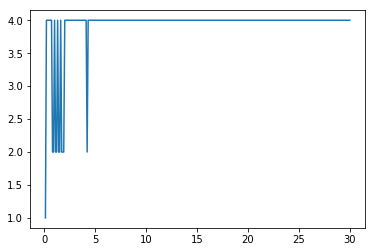

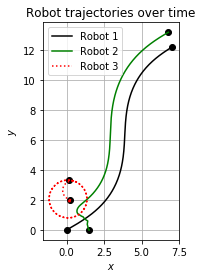

In [0]:
# Plotting results
modePlotter(_modeHISTORY, "mode2.eps")

trajectoryPlotter(_xHISTORY, _yHISTORY, "traj2.eps")


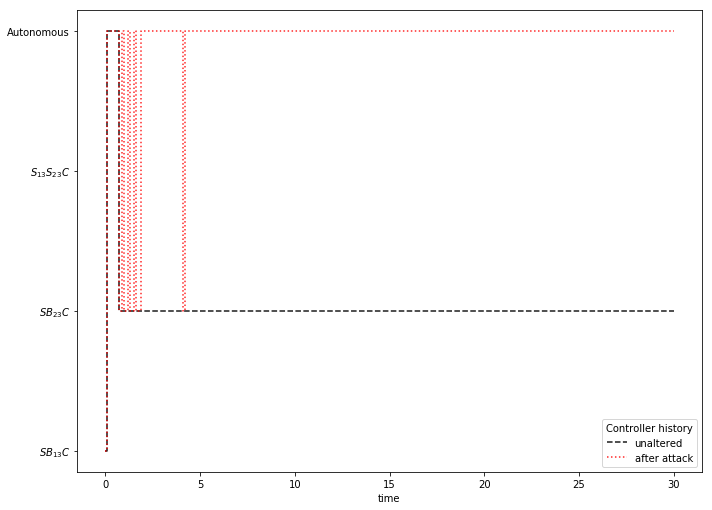

In [0]:
# comparing modes
plt.figure(figsize = (10,7))
plt.step(tHISTORY, modeHISTORY, 
         'k:', alpha = 0.9, label='unaltered',
         linestyle = '--')
plt.step(tHISTORY, _modeHISTORY,
         'r:', alpha = 0.85,label='after attack',
         linestyle = ':')
plt.legend(title='Controller history',loc='lower right')
plt.yticks([1,2,3,4])
ylabels = ['$SB_{13}C$','$SB_{23}C$','$S_{13}S_{23}C$','Autonomous']
ax = plt.gca()
ax.set_yticklabels(ylabels)
# ax.set_facecolor('w')
# ax.set_visible(True)
plt.tight_layout()
plt.xlabel("time")
plt.savefig("modes.eps")
files.download("modes.eps")
plt.show()


## Confusion matrix of NN

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import seaborn as sn
import pandas as pd

[[110   0   0  21]
 [  0  76   0  66]
 [  5   6   0  15]
 [ 23   0   0 178]]


MessageError: ignored

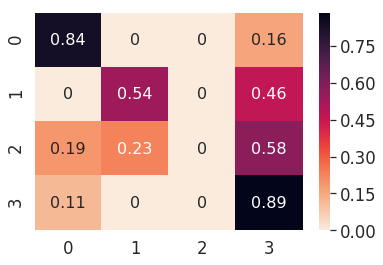

In [0]:
y_true = labels
y_pred = supervisorApprox.predict_classes(data)
nClasses = 4
with tf.Session() as sess:
  confusion_matrix = tf.confusion_matrix(labels=y_true,
                                         predictions=y_pred, 
                                         num_classes=nClasses)
  confusion_matrix_to_Print = sess.run(confusion_matrix)
  normalized_confusion = normalize(confusion_matrix_to_Print, 
                                   axis=1, norm='l1')
  print(confusion_matrix_to_Print)

   
df_cm = pd.DataFrame(normalized_confusion, 
                     range(nClasses),range(nClasses))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.5) #for label size
sn.heatmap(df_cm, cmap =  sn.cm.rocket_r, 
           annot=True,
           annot_kws={"size": 16}) # font size
plt.savefig("confusion.eps")
files.download("confusion.eps")

## ROC Analysis

See this link for source:
[https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/](https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/)

In [0]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [0]:
supervisorApprox = NN_arch()
supervisorApprox.build((None, nDim))
print(supervisorApprox.summary())
nClasses = 4
supervisorApprox.compile(loss="mean_squared_error", 
                    optimizer = "adam", 
                    metrics = ['accuracy'])
supervisorApprox_metaData = supervisorApprox.fit(
                data_train, labels_train, 
                validation_data = (data_test, labels_test), 
                epochs = 100, 
                batch_size = 5, 
                shuffle = True)
#Print accuracy of model on testing set after training 
scores = supervisorApprox.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________
None
Train on 375 samples, validate on 125 samples
Epoch 1/100
375/375 [==============================] - 0s 537us/step - loss: 0.2163 - acc: 0.0507 - val_loss: 0.1983 - val_acc: 0.2640
Epoch 2/100
375/375 [==============================] - 0s 234us/step - loss: 0.1842 - acc: 0.3147 - val_loss: 0.1757 - val_acc: 0.2960
Epoch 3/100
375/375 [==============================] - 0s 239us/ste

In [0]:
y_score = supervisorApprox.predict(data)

y_test = keras.utils.np_utils.to_categorical(labels, num_classes=4)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nClasses):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00334448, 0.00334448, 0.01003344, 0.01003344,
       0.01337793, 0.01337793, 0.02006689, 0.02006689, 0.03010033,
       0.03010033, 1.        ])

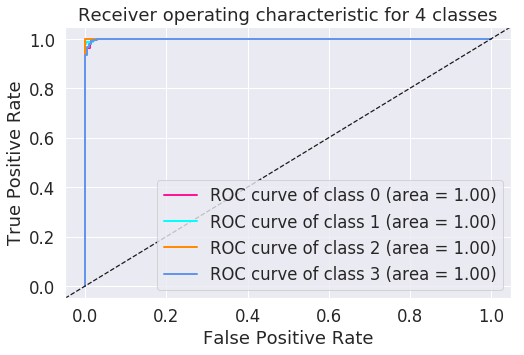

In [0]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nClasses)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(nClasses):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= nClasses

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (8,5))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['deeppink','aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(nClasses), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
# plt.figure(figsize = (15,15))
plt.plot([-0.05, 1.05], [-0.05, 1.05], 'k--', lw=1.25)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 4 classes')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("ROC.png")
files.download("ROC.png")
plt.show()

In [0]:
print(fpr)

{0: array([0., 0., 1.]), 1: array([0.        , 0.01117318, 1.        ]), 2: array([0., 0., 1.]), 3: array([0.        , 0.01672241, 1.        ]), 'micro': array([0.   , 0.006, 1.   ]), 'macro': array([0.        , 0.01117318, 0.01672241, 1.        ])}


# Running for varying number of data points

In [0]:
def query(nQueries):

  data = np.zeros((nQueries, nDim))
  labels = np.zeros(nQueries)
  counts = np.empty((nModes, 1))

  for i in range(nQueries):
    data[i,:] = np.random.uniform(low = Low, high = High, size = (1,2))
    s = SUPER2.switch(DUMMY, data[i,0], data[i,1])
    if s == 1: 
      counts[s-1]+=1
    elif s==2:
      counts[s-1]+=1
    elif s==3:
      counts[s-1]+=1
    else: counts[s-1]+=1
    labels[i] = s-1  # Because label 0 = mode 1 and so on

  return data, labels

def splitter(data, labels, num_classes):
  # Converting labels to one-hot-vectors
  _labels = keras.utils.np_utils.to_categorical(labels, num_classes=4)
  # Splitting dataset
  split = int(0.75*nQueries)
  data_train = data[0:split,:]
  labels_train = _labels[0:split,:]
  data_test = data[split:,:]
  labels_test = _labels[split:,:]
  return data_train, data_test, labels_train, labels_test

def confusionMatrix(data, y_true, nClasses):
  y_pred = supervisorApprox.predict_classes(data)
  with tf.Session() as sess:
    confusion_matrix = tf.confusion_matrix(labels=y_true,
                                          predictions=y_pred, 
                                          num_classes=nClasses)
    confusion_matrix_to_Print = sess.run(confusion_matrix)
    normalized_confusion = normalize(confusion_matrix_to_Print, 
                                   axis=1, norm='l1')
  print(normalized_confusion)
  return normalized_confusion

In [0]:
k = np.logspace(0, 4, num=20)
nClasses = 4
MATS = np.empty((nClasses*nClasses, k.size))
j = 0
for i in k:
  print(i)
  _data, _labels = query(int(i))
  data_train, data_test, labels_train, labels_test = splitter(_data, _labels, nClasses)
  supervisorApprox = NN_arch()
  supervisorApprox.build((None, nDim))
  #This bit trains the NN for a given data set
  supervisorApprox.compile(loss="mean_squared_error", 
                      optimizer = "adam", 
                      metrics = ['accuracy'])
  supervisorApprox_metaData = supervisorApprox.fit(
                  data_train, labels_train, 
                  validation_data = (data_test, labels_test), 
                  epochs = 100, 
                  batch_size = 5, 
                  shuffle = True, verbose = False)
  #Print accuracy of model on testing set after training 
  # scores = supervisorApprox.evaluate(data_test, labels_test)
  # print("Accuracy: %0.4f%%" %(scores[1]*100) )
  # print("Accuracy: %0.4f%%" %(scores[1]*100) )
  cM = confusionMatrix(data, labels, nClasses)
  MATS[:,j] = cM.flatten()
  j+=1

In [0]:
  plt.figure(figsize = (15,15))
sn.set(font_scale=1) #for label size
sn.heatmap(MATS, cmap =  sn.cm.rocket_r, 
           annot=True,
           annot_kws={"size": 16}) # font size

In [0]:
data.shape
_data.shape